In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [19]:
import numpy as np

new_data = pd.DataFrame()
new_data["speed_cubed"] = data["speed"] ** 3
new_data["speed"] = data["speed"]
new_data["speed_times_sine_slop"] = data["speed"] * np.sin(np.arctan(data["slope"]))
new_data["speed_times_acceleration"] = data["speed"] * data["acceleration"].clip(lower=0)

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit, cross_validate

model = make_pipeline(StandardScaler(), RidgeCV())

cv = ShuffleSplit(n_splits=4)

cv_results = cross_validate(
    model, new_data, target, cv=cv, scoring="neg_mean_absolute_error", return_estimator=True, return_train_score=True
)

# Question 1 :

In [21]:
new_data.describe()

,speed_cubed,speed,speed_times_sine_slop,speed_times_acceleration
count,38254.000000,38254.000000,38254.000000,38254.000000
mean,716.713830,8.203325,-0.002710,0.571451
std,631.602968,2.603563,0.249192,1.082863
min,0.000000,0.000000,-1.803089,0.000000
25%,284.760443,6.579000,0.000000,0.000000
50%,571.167214,8.297000,0.000000,0.045422
75%,962.674280,9.874000,0.076831,0.694669
max,6439.008413,18.604000,1.427276,21.015078


# Question 2 :

In [22]:
-cv_results["test_score"].mean()

72.19775926087917

# Question 3 :

In [47]:
coefs = [est[1].coef_ for i, est in enumerate(cv_results["estimator"])]
df_coefs = pd.DataFrame(data=coefs, columns=["beta_1", "beta_2", "beta_3", "beta_4"])

In [48]:
df_coefs

,beta_1,beta_2,beta_3,beta_4
0,6.010469,32.551025,80.915566,11.181004
1,5.178948,33.091881,80.232008,11.062644
2,5.024813,33.332799,80.549363,11.279906
3,5.115768,33.234051,80.277634,11.131814


# Question 4 :

In [49]:
from sklearn.ensemble import HistGradientBoostingRegressor

boosting_regressor = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)

cv_results_boosting = cross_validate(
    boosting_regressor, data, target, cv=cv, scoring="neg_mean_absolute_error", return_estimator=True, return_train_score=True
)

In [52]:
-cv_results_boosting["test_score"].mean()

43.83893705555787

# Question 5 :

In [57]:
errors_SS_lm = -cv_results["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")
errors_SS_lm = -cv_results["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")

errors_SS_hgbdt = -cv_results_boosting["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")
errors_SS_hgbdt = -cv_results_boosting["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.497 +/- 0.148 Watts
Linear model - MAE on test sets:	 72.198 +/- 1.392 Watts
Histogram GBDT - MAE on train sets:	 39.634 +/- 0.300 Watts
Histogram GBDT - MAE on test sets:	 43.839 +/- 0.673 Watts


# Question 6 :

In [70]:
data.index.astype(str).str.slice(0,10).nunique()

4

# Question 7 :

In [88]:
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(new_data.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    model, new_data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    boosting_regressor, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors_LOGO_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")
errors_LOGO_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")

errors_LOGO_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
errors_LOGO_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.249 +/- 2.247 Watts
Linear model - MAE on test sets:	 73.015 +/- 5.779 Watts
Histogram GBDT - MAE on train sets:	 38.865 +/- 2.259 Watts
Histogram GBDT - MAE on test sets:	 49.209 +/- 3.009 Watts


# Question 10 bis :

In [89]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = new_data.iloc[train_indices]
data_linear_model_test = new_data.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

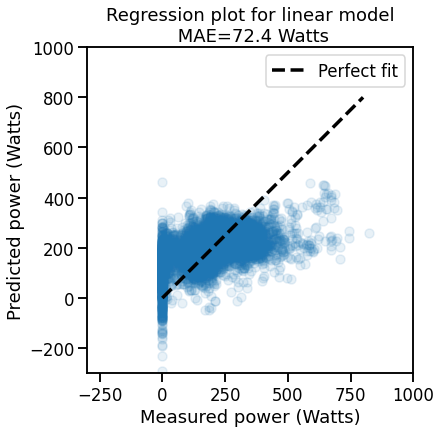

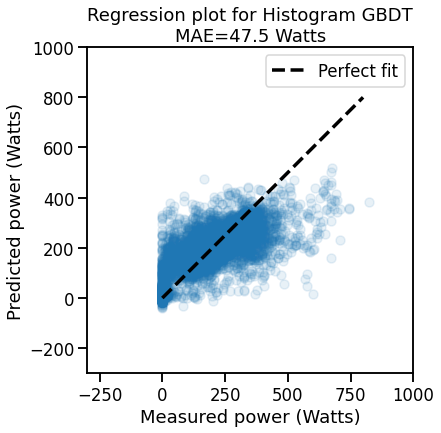

In [90]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# fit models and collect predictions
model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = model.predict(data_linear_model_test)

boosting_regressor.fit(data_train, target_train)
target_predicted_hgbdt = boosting_regressor.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

# Question 11 :

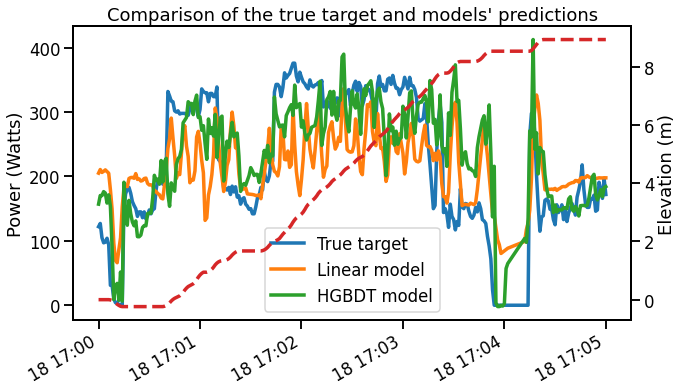

In [93]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = boosting_regressor.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")